In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import dependencies
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from config import awspassword

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import LabelEncoder

In [4]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import sqlalchemy 
import pandas

In [6]:
#### DB Connection configuration
username = "postgres"
password = awspassword
endpoint = "us-accident.cnnhjjyro1tm.us-east-1.rds.amazonaws.com"  # something like amazonaws.com:5432
dbname   = "US_Accident"

In [7]:
## Connect to Db
con = sqlalchemy.create_engine("postgresql://%s:%s@%s/%s" % (username, password, endpoint, dbname))

In [8]:
## Get Data
accident_df = pandas.read_sql("select * from mock_accident;", con)
print(accident_df)

         index       ID  Severity          Start_Time            End_Time  \
0      2565499  2565500         4 2018-12-27 15:16:00 2018-12-27 15:45:26   
1      2227498  2227499         2 2020-03-30 11:39:13 2020-03-30 12:09:13   
2      2265137  2265138         1 2020-04-19 22:50:11 2020-04-19 23:20:11   
3       632007   632008         2 2021-12-18 03:30:17 2021-12-18 05:31:28   
4      1486973  1486974         2 2021-05-26 14:01:53 2021-05-26 16:05:53   
...        ...      ...       ...                 ...                 ...   
49995  1689248  1689249         2 2021-02-12 15:37:00 2021-02-12 16:58:54   
49996  1140100  1140101         2 2021-10-22 20:07:00 2021-10-22 23:03:51   
49997   237035   237036         2 2021-12-10 11:59:22 2021-12-10 13:17:26   
49998  2293039  2293040         2 2020-01-09 19:49:00 2020-01-09 21:03:01   
49999  1224025  1224026         2 2021-10-29 21:28:00 2021-10-29 22:43:46   

       Start_Lat   Start_Lng  Distance(mi)              Street Side  ...  \

### How Severity the Accidents is ?

In [9]:
accident_df.head()

,index,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Street,Side,...,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Year,Month,Day,Hour,Weekday,time_duration
0,2565499,2565500,4,2018-12-27 15:16:00,2018-12-27 15:45:26,42.852850,-85.530930,0.968,Paul B Henry Fwy W,R,...,False,False,False,Day,2018,Dec,27,15,Thu,29.0
1,2227498,2227499,2,2020-03-30 11:39:13,2020-03-30 12:09:13,37.605350,-77.455000,0.000,Brook Rd,R,...,False,False,False,Day,2020,Mar,30,11,Mon,30.0
2,2265137,2265138,1,2020-04-19 22:50:11,2020-04-19 23:20:11,33.385630,-111.895600,0.000,Superstition Fwy E,R,...,False,False,False,Night,2020,Apr,19,22,Sun,30.0
3,632007,632008,2,2021-12-18 03:30:17,2021-12-18 05:31:28,44.969210,-93.287802,0.583,I-94 E,R,...,False,True,False,Night,2021,Dec,18,3,Sat,121.0
4,1486973,1486974,2,2021-05-26 14:01:53,2021-05-26 16:05:53,35.215672,-80.782154,0.111,Central Ave,L,...,False,False,False,Day,2021,May,26,14,Wed,124.0


In [10]:
accident_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              50000 non-null  int64         
 1   ID                 50000 non-null  int64         
 2   Severity           50000 non-null  int64         
 3   Start_Time         50000 non-null  datetime64[ns]
 4   End_Time           50000 non-null  datetime64[ns]
 5   Start_Lat          50000 non-null  float64       
 6   Start_Lng          50000 non-null  float64       
 7   Distance(mi)       50000 non-null  float64       
 8   Street             50000 non-null  object        
 9   Side               50000 non-null  object        
 10  City               50000 non-null  object        
 11  County             50000 non-null  object        
 12  State              50000 non-null  object        
 13  Zipcode            50000 non-null  object        
 14  Timezo

In [11]:
#Drop the null columns where all values are null
accident_df=accident_df.dropna(axis='columns',how='all')

In [12]:
accident_df.shape

(50000, 44)

In [13]:
print(accident_df.columns)

Index(['index', 'ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'Distance(mi)', 'Street', 'Side', 'City', 'County',
       'State', 'Zipcode', 'Timezone', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Year', 'Month', 'Day', 'Hour',
       'Weekday', 'time_duration'],
      dtype='object')


In [14]:
#drop the non-beneficial columns
accident_df=accident_df.drop(columns=['ID','Start_Time','End_Time','Zipcode','index'])
#reaso for droping columns
#ID: since they don't carry any information for the severity
#Start_Time,End_Time :because it was decomposed by the time features added before (day, month, weekday,Year)
#Zipcode :because we just focus on the City,County,state where the accident happened


In [15]:
accident_df.shape

(50000, 39)

In [16]:
accident_df.dtypes

Severity               int64
Start_Lat            float64
Start_Lng            float64
Distance(mi)         float64
Street                object
Side                  object
City                  object
County                object
State                 object
Timezone              object
Temperature(F)       float64
Wind_Chill(F)        float64
Humidity(%)          float64
Pressure(in)         float64
Visibility(mi)       float64
Wind_Direction        object
Wind_Speed(mph)      float64
Precipitation(in)    float64
Weather_Condition     object
Amenity                 bool
Bump                    bool
Crossing                bool
Give_Way                bool
Junction                bool
No_Exit                 bool
Railway                 bool
Roundabout              bool
Station                 bool
Stop                    bool
Traffic_Calming         bool
Traffic_Signal          bool
Turning_Loop            bool
Sunrise_Sunset        object
Year                   int64
Month         

In [17]:
# Determine the number of unique values in each column.
accident_df.nunique()

Severity                 4
Start_Lat            46110
Start_Lng            46177
Distance(mi)          4540
Street               17038
Side                     2
City                  4683
County                 989
State                   49
Timezone                 4
Temperature(F)         174
Wind_Chill(F)          374
Humidity(%)            100
Pressure(in)           781
Visibility(mi)          34
Wind_Direction          23
Wind_Speed(mph)         64
Precipitation(in)       91
Weather_Condition       70
Amenity                  2
Bump                     2
Crossing                 2
Give_Way                 2
Junction                 2
No_Exit                  2
Railway                  2
Roundabout               2
Station                  2
Stop                     2
Traffic_Calming          2
Traffic_Signal           2
Turning_Loop             1
Sunrise_Sunset           2
Year                     6
Month                   12
Day                     31
Hour                    24
W

In [18]:
#Drop Null coluns
accident_df=accident_df.drop(columns=[])

In [19]:
#Drop Null values
accident_df=accident_df.dropna()

In [20]:
accident_df.shape

(50000, 39)

In [21]:
# examine home _ownwrship
street_count=accident_df['Street'].value_counts()

In [22]:
list(street_count[street_count<20].index)

[' W Cary St',
 'I-465 E',
 'CA-24 W',
 'I-440 E',
 'Capital City Fwy W',
 'I-440 W',
 'VA Beach Norfolk Expy E',
 ' W Slauson Ave',
 'CA-15 S',
 ' NE Miami Gardens Dr',
 'Ronald Reagan Tpke',
 'CA-1 S',
 'I-93 N',
 'I-435 S',
 ' US Highway 301 S',
 'Grand Central Pkwy W',
 'CA-2 S',
 ' NW 67th Ave',
 'US-131 S',
 ' SW 40th St',
 ' Ben C Pratt/6 Mile Cypress Pkwy',
 ' World Center Dr',
 'CA-58 W',
 'I-476 N',
 ' NW 167th St',
 'Governor John Davis Lodge Tpke S',
 'I-69 N',
 ' NW 183rd St',
 'CA-180 W',
 'Chrysler Expy N',
 ' Highway 1',
 ' Lee Hwy',
 'US-22 E',
 ' Murfreesboro Pike',
 'I-190 N',
 ' NE 123rd St',
 ' S Azusa Ave',
 'Cross Westchester Expy W',
 'Tom Landry Fwy',
 ' Airline Hwy',
 'I-45 S',
 ' Highway 58',
 ' Washington Blvd',
 ' 53rd Ave E',
 ' N Pine Hills Rd',
 'Belt Pkwy E',
 ' N Hiawassee Rd',
 'Black Canyon Fwy N',
 ' NW 107th Ave',
 ' Broadway',
 ' US Highway 19',
 ' Highway 101 S',
 'Adirondack Northway S',
 ' Blanding Blvd',
 'GA-407 W',
 ' W Cheltenham Ave',
 ' H

In [23]:
# Determine which values to replace if counts are less than ...? less than 20
replace_street = list(street_count[street_count<20].index)

# Replace in dataframe
for street in replace_street:
    accident_df.Street = accident_df.Street.replace(street,"Other")
    
# Check to make sure binning was successful
accident_df.Street.value_counts()

Other                      30868
I-5 N                        702
I-95 N                       694
I-95 S                       664
I-5 S                        534
                           ...  
 Turkey Lake Rd               20
 Florence Ave                 20
I-376 E                       20
VA Beach Norfolk Expy W       20
 NW 72nd Ave                  20
Name: Street, Length: 280, dtype: int64

In [24]:
#replace all bollean values to integer
accident_df.replace({False: 0, True: 1}, inplace=True)

In [25]:
accident_df.dtypes

Severity               int64
Start_Lat            float64
Start_Lng            float64
Distance(mi)         float64
Street                object
Side                  object
City                  object
County                object
State                 object
Timezone              object
Temperature(F)       float64
Wind_Chill(F)        float64
Humidity(%)          float64
Pressure(in)         float64
Visibility(mi)       float64
Wind_Direction        object
Wind_Speed(mph)      float64
Precipitation(in)    float64
Weather_Condition     object
Amenity                int64
Bump                   int64
Crossing               int64
Give_Way               int64
Junction               int64
No_Exit                int64
Railway                int64
Roundabout             int64
Station                int64
Stop                   int64
Traffic_Calming        int64
Traffic_Signal         int64
Turning_Loop           int64
Sunrise_Sunset        object
Year                   int64
Month         

In [26]:
# check Severity column
accident_df['Severity'].value_counts()

2    46633
3     1433
4     1381
1      553
Name: Severity, dtype: int64

#### converting the string values into numerical ones using label encoder

In [27]:
# To see which columns have categorical value columns
X_cat = accident_df.select_dtypes(include='object').columns
X_cat

Index(['Street', 'Side', 'City', 'County', 'State', 'Timezone',
       'Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset', 'Month',
       'Weekday'],
      dtype='object')

In [28]:
# examine all the columns
for column in accident_df[X_cat]:
    print(column,"\n", accident_df[column].value_counts())
    print("--------------------------------------")

Street 
 Other                      30868
I-5 N                        702
I-95 N                       694
I-95 S                       664
I-5 S                        534
                           ...  
 Turkey Lake Rd               20
 Florence Ave                 20
I-376 E                       20
VA Beach Norfolk Expy W       20
 NW 72nd Ave                  20
Name: Street, Length: 280, dtype: int64
--------------------------------------
Side 
 R    40519
L     9481
Name: Side, dtype: int64
--------------------------------------
City 
 Miami              2364
Los Angeles        1268
Orlando            1117
Dallas              735
Houston             639
                   ... 
Foxboro               1
Nazareth              1
Hettinger             1
Toney                 1
Battle Mountain       1
Name: City, Length: 4683, dtype: int64
--------------------------------------
County 
 Los Angeles       3679
Miami-Dade        3126
Orange            2206
San Bernardino    1019
San Di

In [29]:
from sklearn.preprocessing import LabelEncoder
#
# Instantiate LabelEncoder
#
le = LabelEncoder()


In [30]:
# Encode single column Side
#
accident_df.Street = le.fit_transform(accident_df.Street)
#
# Print df.head for checking the transformatio

In [31]:
accident_df['Street']

0        261
1        261
2        261
3        249
4          3
        ... 
49995    148
49996    229
49997    261
49998    261
49999    261
Name: Street, Length: 50000, dtype: int32

In [32]:
print(accident_df['Street'].nunique())

280


In [33]:
# Encode single column Side
#
accident_df.Side = le.fit_transform(accident_df.Side)
#
# Print df.head for checking the transformation

In [34]:
accident_df['Side']

0        1
1        1
2        1
3        1
4        0
        ..
49995    1
49996    1
49997    1
49998    1
49999    1
Name: Side, Length: 50000, dtype: int32

In [35]:
# Encode single column City
#
accident_df.City = le.fit_transform(accident_df.City)
#
# Print df.head for checking the transformation

In [36]:
accident_df['City']

0         552
1        3500
2        4126
3        2672
4         702
         ... 
49995    2495
49996     235
49997    2834
49998    1910
49999    3094
Name: City, Length: 50000, dtype: int32

In [37]:
#accident_df['City'].unique().value_counts
print(accident_df['City'].nunique())

4683


In [38]:
# Encode single column County
#
accident_df.County = le.fit_transform(accident_df.County)
#
# Print df.head for checking the transformation

In [39]:
accident_df['County']

0        460
1        400
2        541
3        399
4        560
        ... 
49995    681
49996    487
49997    237
49998    414
49999    646
Name: County, Length: 50000, dtype: int32

In [40]:
print(accident_df['County'].nunique())

989


In [41]:
# Encode single column State
#
accident_df.State = le.fit_transform(accident_df.State)
#
# Print df.head for checking the transformation

In [42]:
accident_df['State']

0        20
1        43
2         2
3        21
4        25
         ..
49995     2
49996    31
49997    40
49998    21
49999     8
Name: State, Length: 50000, dtype: int32

In [43]:
# Encode single column Timezone 
#
accident_df.Timezone  = le.fit_transform(accident_df.Timezone)
#
# Print df.head for checking the transformation

In [44]:
accident_df['Timezone']

0        1
1        1
2        2
3        0
4        1
        ..
49995    2
49996    3
49997    0
49998    0
49999    1
Name: Timezone, Length: 50000, dtype: int32

In [45]:
# Encode single column Wind_Direction 
#
accident_df.Wind_Direction  = le.fit_transform(accident_df.Wind_Direction)
#
# Print df.head for checking the transformation

In [46]:
accident_df['Wind_Direction']

0        12
1        11
2        14
3         7
4        15
         ..
49995    19
49996    20
49997    11
49998    20
49999    11
Name: Wind_Direction, Length: 50000, dtype: int32

In [47]:
# Encode single column Weather_Condition 
#
accident_df.Weather_Condition  = le.fit_transform(accident_df.Weather_Condition)
#
# Print df.head for checking the transformation

In [48]:
accident_df['Weather_Condition']

0        47
1         9
2        40
3        35
4        40
         ..
49995     9
49996     9
49997     5
49998     9
49999    44
Name: Weather_Condition, Length: 50000, dtype: int32

In [49]:
# Encode single column Sunrise_Sunset 
#
accident_df.Sunrise_Sunset  = le.fit_transform(accident_df.Sunrise_Sunset)
#
# Print df.head for checking the transformation

In [50]:
accident_df['Sunrise_Sunset']

0        0
1        0
2        1
3        1
4        0
        ..
49995    0
49996    1
49997    0
49998    1
49999    1
Name: Sunrise_Sunset, Length: 50000, dtype: int32

In [51]:
# Encode single column Day 
#
accident_df.Weekday  = le.fit_transform(accident_df.Weekday)
#
# Print df.head for checking the transformation

In [52]:
accident_df['Weekday']

0        4
1        1
2        3
3        2
4        6
        ..
49995    0
49996    0
49997    0
49998    4
49999    0
Name: Weekday, Length: 50000, dtype: int32

In [53]:
# Encode single column Day 
#
accident_df.Month  = le.fit_transform(accident_df.Month)
#
# Print df.head for checking the transformation

In [54]:
accident_df['Month']

0         2
1         7
2         0
3         2
4         8
         ..
49995     3
49996    10
49997     2
49998     4
49999    10
Name: Month, Length: 50000, dtype: int32

In [55]:
accident_df.dtypes

Severity               int64
Start_Lat            float64
Start_Lng            float64
Distance(mi)         float64
Street                 int32
Side                   int32
City                   int32
County                 int32
State                  int32
Timezone               int32
Temperature(F)       float64
Wind_Chill(F)        float64
Humidity(%)          float64
Pressure(in)         float64
Visibility(mi)       float64
Wind_Direction         int32
Wind_Speed(mph)      float64
Precipitation(in)    float64
Weather_Condition      int32
Amenity                int64
Bump                   int64
Crossing               int64
Give_Way               int64
Junction               int64
No_Exit                int64
Railway                int64
Roundabout             int64
Station                int64
Stop                   int64
Traffic_Calming        int64
Traffic_Signal         int64
Turning_Loop           int64
Sunrise_Sunset         int32
Year                   int64
Month         

#### Split the Data into Training and Testing

In [56]:
# Create our features
X = accident_df.drop("Severity",axis=1) 
X.head()

,Start_Lat,Start_Lng,Distance(mi),Street,Side,City,County,State,Timezone,Temperature(F),...,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Year,Month,Day,Hour,Weekday,time_duration
0,42.852850,-85.530930,0.968,261,1,552,460,20,1,41.0,...,0,0,0,0,2018,2,27,15,4,29.0
1,37.605350,-77.455000,0.000,261,1,3500,400,43,1,64.0,...,0,0,0,0,2020,7,30,11,1,30.0
2,33.385630,-111.895600,0.000,261,1,4126,541,2,2,73.0,...,0,0,0,1,2020,0,19,22,3,30.0
3,44.969210,-93.287802,0.583,249,1,2672,399,21,0,18.0,...,0,1,0,1,2021,2,18,3,2,121.0
4,35.215672,-80.782154,0.111,3,0,702,560,25,1,92.0,...,0,0,0,0,2021,8,26,14,6,124.0


##### Check features variance
In this section we are going to check the variance for each feature in order to remove features with a very low variance beacuse they can't help to discriminate instances.

In [57]:
X.describe()

,Start_Lat,Start_Lng,Distance(mi),Street,Side,City,County,State,Timezone,Temperature(F),...,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Year,Month,Day,Hour,Weekday,time_duration
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.0,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.00000
mean,35.960047,-96.577087,0.693420,224.700060,0.810380,2381.384340,529.069920,18.188840,1.549500,61.935894,...,0.000760,0.097980,0.0,0.373320,2020.530420,5.70594,16.217660,12.881380,2.994760,319.40340
std,5.502761,18.254669,1.425562,64.227333,0.392004,1279.966268,241.238326,15.135792,1.115031,18.523858,...,0.027558,0.297291,0.0,0.483691,0.723744,3.55149,8.681357,5.901204,2.105807,8459.43657
min,24.574762,-124.495510,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-25.000000,...,0.000000,0.000000,0.0,0.000000,2016.000000,0.00000,1.000000,0.000000,0.000000,4.00000
25%,32.912523,-117.972069,0.047000,206.000000,1.000000,1312.000000,366.000000,3.000000,1.000000,50.000000,...,0.000000,0.000000,0.0,0.000000,2020.000000,2.00000,9.000000,8.000000,1.000000,73.00000
50%,35.604236,-90.533685,0.211000,261.000000,1.000000,2595.000000,560.000000,10.000000,1.000000,64.000000,...,0.000000,0.000000,0.0,0.000000,2021.000000,6.00000,16.000000,14.000000,3.000000,105.00000
75%,40.047596,-80.333664,0.782000,261.000000,1.000000,3455.000000,717.000000,35.000000,3.000000,76.000000,...,0.000000,0.000000,0.0,1.000000,2021.000000,9.00000,24.000000,17.000000,5.000000,154.00000
max,48.945947,-68.543684,64.941000,279.000000,1.000000,4682.000000,988.000000,48.000000,3.000000,114.000000,...,1.000000,1.000000,0.0,1.000000,2021.000000,11.00000,31.000000,23.000000,6.000000,525705.00000


In [58]:
X['Precipitation(in)'].describe()

count    50000.000000
mean         0.006099
std          0.065791
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          9.990000
Name: Precipitation(in), dtype: float64

In [59]:
X['Pressure(in)'].describe()

count    50000.000000
mean        29.370670
std          1.097835
min         20.250000
25%         29.210000
50%         29.740000
75%         29.970000
max         30.700000
Name: Pressure(in), dtype: float64

Even though Precipitation and Pressure have a small variance, there is no need to drop them since they usually have small increments.

In [60]:
#Create our target
y = accident_df['Severity']
y.value_counts()

2    46633
3     1433
4     1381
1      553
Name: Severity, dtype: int64

In [61]:
# examine shape of X

X.shape

(50000, 38)

In [62]:
y.shape

(50000,)

#### Split encoded Data into Training and Testing

In [63]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 1)

In [64]:
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [65]:
y_train.value_counts()

2    34947
3     1108
4     1022
1      423
Name: Severity, dtype: int64

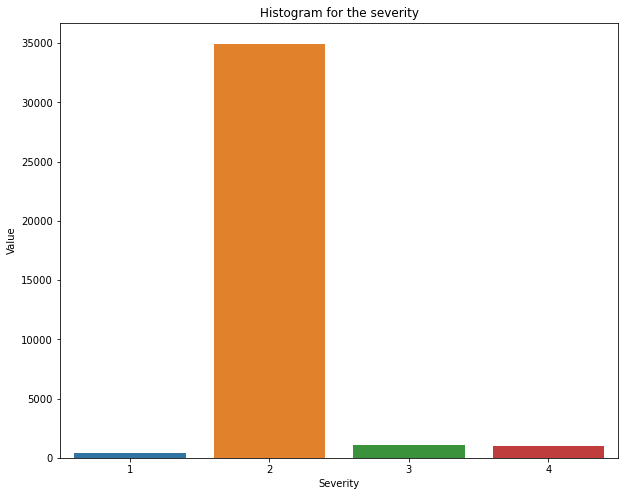

In [66]:
# imbalanced data set
import matplotlib.pyplot 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

severity_counts = y_train.value_counts()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(severity_counts.index, severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

In [67]:
#logistic regression before resampling
# Train the Logistic Regression model before resampling data
#model
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs',random_state=1)
#fit
clf.fit(X,y)
#predict using the predict method
y_pred = clf.predict(X_test)

In [68]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test,y_pred)

0.25

## Handle unbalanced data

### Oversampling
###### In this section, compared two oversampling algorithms to determine which algorithm results in the best performance.And oversampled the data using the naive random oversampling algorithm and the SMOTE algorithm. 


#### Naive Random Oversampling

In [69]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled,y_resampled =ros.fit_resample(X_train,y_train)

In [70]:
# what is the "balance" or mix between Severity
Counter(y_resampled)

Counter({2: 34947, 4: 34947, 3: 34947, 1: 34947})

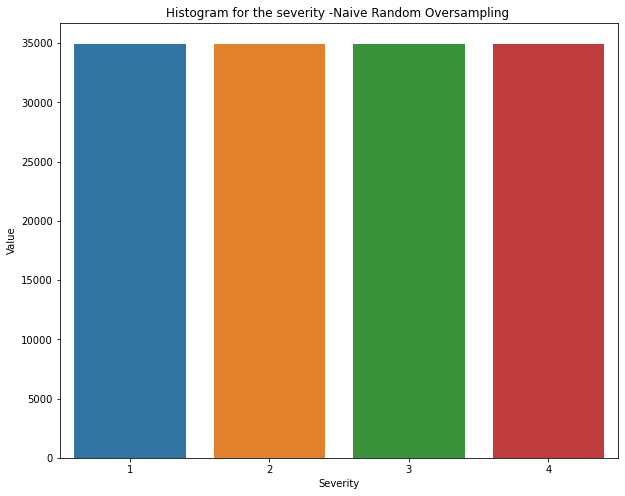

In [71]:
severity_counts = y_resampled.value_counts()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity -Naive Random Oversampling ")
sns.barplot(severity_counts.index, severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

In [72]:
# Train the Logistic Regression model using the resampled data
#model
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs',random_state=1)
#fit
clf.fit(X_resampled,y_resampled)
#predict using the predict method
y_pred = clf.predict(X_test)

In [73]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
Naive_acuracy = balanced_accuracy_score(y_test,y_pred)
Naive_acuracy

0.4611353806871549

In [74]:
# Display the confusion matrix
cm = confusion_matrix(y_test,y_pred,labels=clf.classes_)
cm

array([[  82,    5,   38,    5],
       [1566, 3987, 1599, 4534],
       [ 119,   18,  165,   23],
       [  67,   53,  108,  131]], dtype=int64)

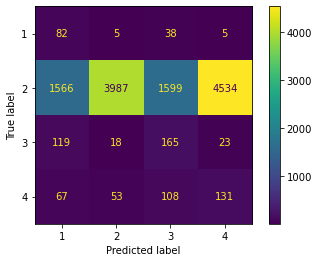

In [75]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= clf.classes_)
disp.plot()

In [76]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.04      0.63      0.86      0.08      0.74      0.53       130
          2       0.98      0.34      0.91      0.51      0.56      0.29     11686
          3       0.09      0.51      0.86      0.15      0.66      0.42       325
          4       0.03      0.36      0.62      0.05      0.48      0.22       359

avg / total       0.92      0.35      0.90      0.48      0.56      0.30     12500



#### SMOTE Oversampling

In [77]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(
   X_train, y_train)

In [78]:
#check the balance of Loan_status
Counter(y_resampled)

Counter({2: 34947, 4: 34947, 3: 34947, 1: 34947})

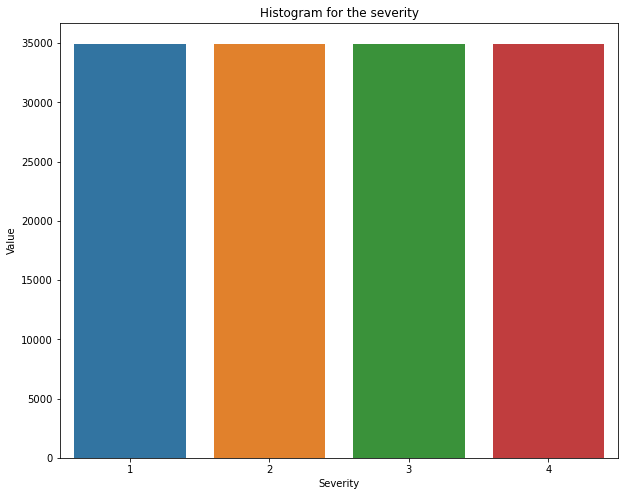

In [79]:
severity_counts = y_resampled.value_counts()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(severity_counts.index, severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

In [80]:
# Train the Logistic Regression model using the resampled data
#model
clf = LogisticRegression(solver='lbfgs', random_state=1)

#train/fit
clf.fit(X_resampled, y_resampled)

#predict
y_pred = clf.predict(X_test)

In [81]:
# Calculated the balanced accuracy score
SMOTE_acuracy = balanced_accuracy_score(y_test, y_pred)

In [82]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[  80,    7,   35,    8],
       [1214, 4046, 1550, 4876],
       [ 111,   32,  147,   35],
       [  60,   56,  100,  143]], dtype=int64)

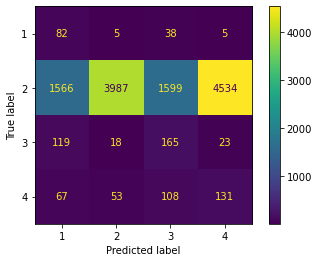

In [83]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= clf.classes_)
disp.plot()

In [84]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.05      0.62      0.89      0.10      0.74      0.53       130
          2       0.98      0.35      0.88      0.51      0.55      0.29     11686
          3       0.08      0.45      0.86      0.14      0.62      0.37       325
          4       0.03      0.40      0.59      0.05      0.49      0.23       359

avg / total       0.92      0.35      0.87      0.48      0.55      0.29     12500



### Undersampling
###### In this section, tested an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above.  undersampled the data using the Cluster Centroids algorithm

#### ClusterCentroids resampler

In [85]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

#### Logistic Regression using the resampled data

In [86]:
# Train the Logistic Regression model using the resampled data
#model
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs',random_state=1)
#fit
clf.fit(X_resampled,y_resampled)
#predict using the predict method
y_pred = clf.predict(X_test)

In [87]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
ClusterCentroids_accuracy = balanced_accuracy_score(y_test,y_pred)
ClusterCentroids_accuracy


0.40224218544669366

In [88]:
# Display the confusion matrix
cm = confusion_matrix(y_test,y_pred,labels=clf.classes_)
cm

array([[  92,    1,   36,    1],
       [2366, 2247, 5025, 2048],
       [ 143,   13,  158,   11],
       [ 101,   38,  140,   80]], dtype=int64)

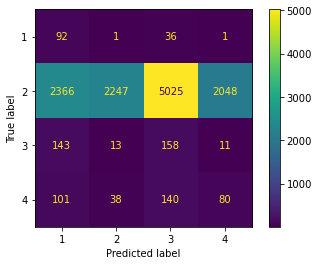

In [89]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= clf.classes_)
disp.plot()

In [90]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.03      0.71      0.79      0.06      0.75      0.55       130
          2       0.98      0.19      0.94      0.32      0.42      0.17     11686
          3       0.03      0.49      0.57      0.06      0.53      0.28       325
          4       0.04      0.22      0.83      0.06      0.43      0.17       359

avg / total       0.92      0.21      0.92      0.30      0.43      0.17     12500



#### Combination (Over and Under) Sampling
###### In this section, tested a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above.  Resampled the data using the SMOTEENN algorithm .

##### SMOTEENN algorithm

In [91]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete

                                                    
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)       
Counter(y_resampled)

Counter({1: 34844, 2: 26156, 3: 34414, 4: 34205})

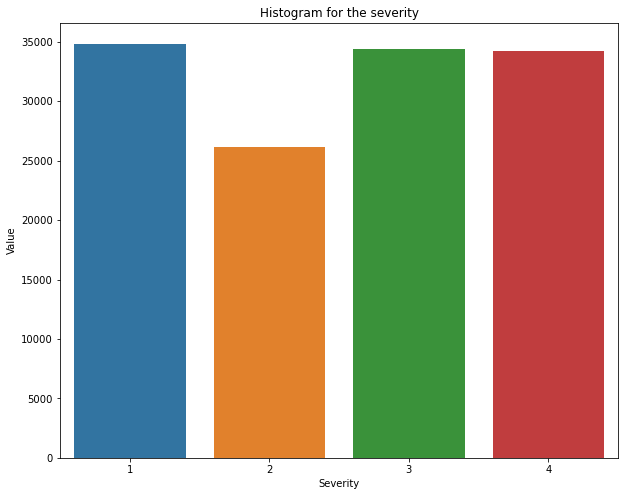

In [92]:
severity_counts = y_resampled.value_counts()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(severity_counts.index, severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

#### Logistic Regression using the resampled(Over and Under) data

In [93]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
#model
clf = LogisticRegression(solver='lbfgs', random_state=1)
#fit
clf.fit(X_resampled, y_resampled)
#predict
y_pred = clf.predict(X_test)

In [94]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
SMOTEENN_accuracy = balanced_accuracy_score(y_test, y_pred)

In [95]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred,labels=clf.classes_)
cm

array([[  83,    6,   33,    8],
       [1517, 2630, 1529, 6010],
       [ 123,   18,  156,   28],
       [  64,   32,  105,  158]], dtype=int64)

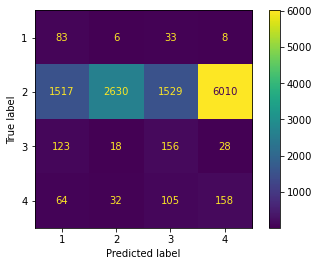

In [96]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= clf.classes_)
disp.plot()

In [97]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.05      0.64      0.86      0.09      0.74      0.54       130
          2       0.98      0.23      0.93      0.37      0.46      0.19     11686
          3       0.09      0.48      0.86      0.15      0.64      0.40       325
          4       0.03      0.44      0.50      0.05      0.47      0.22       359

avg / total       0.92      0.24      0.92      0.35      0.47      0.20     12500



#### Ensemble Learners
###### In this section,  compared two ensemble algorithms to determine which algorithm results in the best performance. trained a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier .

#### Balanced Random Forest Classifier

In [98]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import EasyEnsembleClassifier

In [99]:
# Resample the training data with the BalancedRandomForestClassifier

#model
brf_model = BalancedRandomForestClassifier(random_state=1, n_estimators=100)
#fit
brf_model = brf_model.fit(X_train, y_train)

#predict
predictions = brf_model.predict(X_test)


AttributeError: can't set attribute

In [ ]:
# Calculated the balanced accuracy score
RandomForest_accuracy = balanced_accuracy_score(y_test,predictions)
RandomForest_accuracy



In [ ]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1","Actual 2", "Actual 3"], columns=["Predicted 0", "Predicted 1","Predicted 2", "Predicted 3"])

cm_df

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= clf.classes_)
disp.plot()


In [ ]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

In [ ]:
# We can sort the features by their importance.
sorted (zip(brf_model.feature_importances_,X.columns),reverse=True)

In [ ]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=["importance"], index=X_train.columns)

importances.iloc[:,0] = brf_model.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:40]

plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.title("Features by their importance -Random Forest Classifier")
plt.show()

#### Easy Ensemble AdaBoost classifier .

In [ ]:
# Train the EasyEnsembleClassifier
# YOUR CODE HERE
from imblearn.ensemble import EasyEnsembleClassifier
#model
ee_clf = EasyEnsembleClassifier(n_estimators=100,random_state=1)
#fit/train
ee_clf.fit(X_train,y_train)
#predict
y_pred=ee_clf.predict(X_test)

In [ ]:
# Calculated the balanced accuracy score
AdaBoost_classifier_accuracy = balanced_accuracy_score(y_test,y_pred)
AdaBoost_classifier_accuracy

In [ ]:
# Display the confusion matrix
confusion_matrix(y_test,y_pred)

In [ ]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

In [ ]:
# Report
#train_data=[(accuracy_train*100), (tree_accuracy_train*100), (rf_train_accuracy*100),(xgb_accuracy_train*100)]
accuracy=[(Naive_acuracy*100), (SMOTE_acuracy*100), (ClusterCentroids_accuracy*100),(SMOTEENN_accuracy*100),(RandomForest_accuracy*100),(AdaBoost_classifier_accuracy*100)]

#F1_score = [f1_lr,f1_tree,f1_rf,f1_xgb]

    
df = {'Algorithm': ['Naive Random Oversampling','SMOTE Oversampling','ClusterCentroids resampler','SMOTEENN algorithm','Random Forest Classifier','Easy Ensemble AdaBoost classifier'], \
      'Acuuracy_Score':accuracy}

#Report = pd.DataFrame(data=df, columns=['Algorithm','Train Data', 'Test Data', 'F1-score'], index=None)
Report = pd.DataFrame(data=df, columns=['Algorithm','Acuuracy_Score'], index=None)
Report